In [1]:
import pandas as pd
from processor.processor import Processor as processor
from database.adatabase import ADatabase
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
from datetime import datetime
from arch import arch_model

In [2]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [3]:
def calculate_technical_indicators(price):
    # Average Return
    price["average_return"] = price["adjclose"].pct_change(5).rolling(100).mean()
    price["prev_return"] = price["adjclose"].pct_change(5)
    
    # Coefficient of Variation
    price["coev"] = price["adjclose"].rolling(100).std() / price["adjclose"].rolling(100).mean()
    price["return_to_risk"] = price["prev_return"] / price["coev"]
    
    # Bollinger Bands
    price["bollinger"] = ((price["adjclose"].rolling(100).mean() - 2 * price["adjclose"].rolling(100).std()) - price["adjclose"]) / price["adjclose"]

    # RSI (Relative Strength Index)
    delta = price["adjclose"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    price["rsi"] = 100 - (100 / (1 + rs))

    # MACD (Moving Average Convergence Divergence)
    ema_12 = price["adjclose"].ewm(span=12, adjust=False).mean()
    ema_26 = price["adjclose"].ewm(span=26, adjust=False).mean()
    price["macd"] = ema_12 - ema_26
    price["signal_line"] = price["macd"].ewm(span=9, adjust=False).mean()

    # EMA (Exponential Moving Average)
    price["ema_20"] = price["adjclose"].ewm(span=20, adjust=False).mean()

    # ATR (Average True Range)
    high_low = price["adjhigh"] - price["adjlow"]
    high_close = np.abs(price["adjhigh"] - price["adjclose"].shift())
    low_close = np.abs(price["adjlow"] - price["adjclose"].shift())
    tr = high_low.combine(high_close, np.maximum).combine(low_close, np.maximum)
    price["atr"] = tr.rolling(14).mean()

    # Stochastic Oscillator
    low_14 = price["adjlow"].rolling(window=14).min()
    high_14 = price["adjhigh"].rolling(window=14).max()
    price["stochastic"] = (price["adjclose"] - low_14) / (high_14 - low_14) * 100

    # On-Balance Volume (OBV)
    price["obv"] = (np.sign(price["adjclose"].diff()) * price["volume"]).fillna(0).cumsum()

    # Chaikin Money Flow (CMF)
    money_flow_multiplier = ((price["adjclose"] - price["adjlow"]) - (price["adjhigh"] - price["adjclose"])) / (price["adjhigh"] - price["adjlow"])
    money_flow_volume = money_flow_multiplier * price["volume"]
    price["cmf"] = money_flow_volume.rolling(window=20).sum() / price["volume"].rolling(window=20).sum()

    # Williams %R
    price["williams_r"] = (price["adjhigh"].rolling(14).max() - price["adjclose"]) / (price["adjhigh"].rolling(14).max() - price["adjlow"].rolling(14).min()) * -100

    # Commodity Channel Index (CCI)
    typical_price = (price["adjhigh"] + price["adjlow"] + price["adjclose"]) / 3
    price["cci"] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())

    # Parabolic SAR
    # price["psar"] = ta.trend.psar(high=price["adjhigh"], low=price["adjlow"], close=price["adjclose"], step=0.02, max_step=0.2)
    # Ichimoku Cloud
    price["tenkan_sen"] = (price["adjhigh"].rolling(9).max() + price["adjlow"].rolling(9).min()) / 2
    price["kijun_sen"] = (price["adjhigh"].rolling(26).max() + price["adjlow"].rolling(26).min()) / 2
    price["senkou_span_a"] = (price["tenkan_sen"] + price["kijun_sen"]) / 2
    price["senkou_span_b"] = (price["adjhigh"].rolling(52).max() + price["adjlow"].rolling(52).min()) / 2
    
    # Force Index
    price["force_index"] = price["adjclose"].diff() * price["volume"]
    
    # Elder's Impulse System
    price["elder_impulse"] = np.where((price["adjclose"] > price["adjclose"].shift()) & (price["volume"] > price["volume"].shift()), 1, 0)
    
    # Keltner Channel
    price["keltner_upper"] = price["adjclose"].rolling(20).mean() + 2 * price["adjclose"].rolling(20).std()
    price["keltner_lower"] = price["adjclose"].rolling(20).mean() - 2 * price["adjclose"].rolling(20).std()
    return price

In [57]:
def fit_garch_model(price):
    # Calculate returns
    returns = price["adjclose"].pct_change(5).dropna()
    
    # Fit ARMA(1,1) model with GARCH(1,1) errors
    model = arch_model(returns, mean='AR', lags=1, vol='Garch', p=1, q=1)
    garch_fit = model.fit(disp='off')
    
    # Make predictions
    forecasts = garch_fit.forecast(horizon=returns.size)
    mean_forecast = forecasts.mean
    variance_forecast = forecasts.variance.iloc[-1, :]
    forecasts = [0 for i in range(price.index.size - len(mean_forecast.values[0]))]
    forecasts.extend(mean_forecast.values[0])
    price["garch"] = forecasts
    return price

In [58]:
prices = []
market = ADatabase("market")
market.connect()
for ticker in tqdm(sp500["ticker"][:1]):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker})).sort_values("date")
        price = calculate_technical_indicators(price)
        price = fit_garch_model(price)
        prices.append(price.dropna())
    except Exception as e:
        print(ticker, str(e))
        continue
market.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


In [46]:
prices = pd.concat(prices).sort_values("date")

In [47]:
price

,date,adjclose,adjlow,adjhigh,volume,ticker,average_return,prev_return,coev,return_to_risk,...,cci,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,force_index,elder_impulse,keltner_upper,keltner_lower,garch
0,2022-07-22,178.18,177.2550,181.160,1375628,ZTS,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.000000
1,2022-07-25,175.18,174.0900,178.700,1511340,ZTS,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-4534020.00,0,NaN,NaN,0.000000
2,2022-07-26,176.38,173.9600,176.750,1588960,ZTS,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1906752.00,1,NaN,NaN,0.000000
3,2022-07-27,177.47,175.3200,178.135,1613275,ZTS,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1758469.75,1,NaN,NaN,0.000000
4,2022-07-28,182.27,177.3501,183.805,1506895,ZTS,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7233096.00,0,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2024-07-16,182.91,177.7800,183.220,1939933,ZTS,-0.001652,0.049759,0.064573,0.770580,...,134.825951,177.365,174.835,176.10,170.63,9563869.69,0,181.508890,166.406110,0.000403
498,2024-07-17,182.05,180.5600,184.840,2190800,ZTS,-0.001842,0.049340,0.063202,0.780672,...,132.983023,178.175,175.645,176.91,172.92,-1884088.00,0,182.732897,166.297103,0.000403
499,2024-07-18,179.23,179.1700,184.240,2171095,ZTS,-0.002157,0.008383,0.061564,0.136168,...,94.690857,178.175,175.645,176.91,172.92,-6122487.90,0,183.135227,166.851773,0.000403
500,2024-07-19,178.58,176.1700,180.510,2131427,ZTS,-0.002642,-0.002569,0.059852,-0.042927,...,48.497151,178.175,175.645,176.91,172.92,-1385427.55,0,183.134770,167.892230,0.000403


In [48]:
factors = [
           "average_return"
            ,"prev_return"
           ,"coev"
           ,"bollinger","rsi","signal_line","ema_20","stochastic","atr","return_to_risk","obv","cmf","williams_r","cci","force_index","elder_impulse"
            ,"keltner_upper","keltner_lower","senkou_span_a","senkou_span_b","garch"
          ]     

In [49]:
prices

,date,adjclose,adjlow,adjhigh,volume,ticker,average_return,prev_return,coev,return_to_risk,...,cci,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,force_index,elder_impulse,keltner_upper,keltner_lower,garch
104,2022-12-19,122.1300,121.1600,123.770,2440223,MMM,-0.004208,-0.037209,0.092715,-0.401330,...,-115.574872,125.01500,126.96000,125.98750,120.49000,1.073698e+06,0,129.891892,121.782108,-0.002457
104,2022-12-19,189.8900,187.8601,204.000,7321698,MRNA,0.014335,0.149942,0.157875,0.949755,...,66.278687,190.01500,189.99500,190.00500,167.78000,-2.489377e+07,0,205.331758,159.707242,-0.002393
104,2022-12-19,155.3100,154.7200,157.380,747666,MAA,-0.003794,-0.050788,0.072485,-0.700672,...,-131.546878,161.72250,161.53750,161.63000,154.92750,-1.712155e+06,0,166.990116,155.559884,-0.001581
104,2022-12-19,240.4500,238.7100,245.210,34123158,MSFT,-0.001564,-0.047760,0.077193,-0.618719,...,-86.203793,251.31250,250.77250,251.04250,238.67300,-1.446822e+08,0,259.116419,237.123581,0.005451
104,2022-12-19,51.7200,51.1000,52.290,19318498,MU,-0.005674,-0.065583,0.070801,-0.926295,...,-118.439731,54.49500,57.77000,56.13250,57.38500,-6.761474e+06,0,59.436013,51.006987,0.005969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,2024-07-22,33.0450,32.7450,33.110,2187296,KDP,0.004713,0.011478,0.058441,0.196409,...,-8.556137,32.70500,33.30500,33.00500,33.40000,1.421742e+05,0,34.608885,31.468615,-0.000653
501,2024-07-22,15.6700,15.2300,15.715,7065188,KEY,0.006357,0.010968,0.043899,0.249838,...,70.333549,15.37000,14.78750,15.07875,14.78750,5.652150e+05,0,16.377730,12.987270,0.003694
501,2024-07-22,841.9801,835.0400,845.500,136890,BLK,0.002187,0.023112,0.033180,0.696554,...,98.920806,826.81800,805.03800,815.92800,802.08550,1.544133e+06,0,852.578005,764.156005,0.001632
501,2024-07-22,158.9900,156.1300,160.820,316235,BLDR,-0.006193,0.037997,0.138878,0.273600,...,85.998402,150.47365,148.99005,149.73185,156.04505,3.130727e+05,0,166.394296,122.205704,0.012584


In [50]:
analysis = []   
for factor in tqdm(factors):
    for ascending in [True,False]:
        default_portfolio = {"ticker":"","adjclose":0,"quantity":0,"buy_price":0}
        cash = 100
        portfolio = default_portfolio.copy()
        portfolios = []
        for date in prices["date"].unique():
            try:
                today = prices[prices["date"]==date]
                rec = today.sort_values(factor,ascending=ascending).iloc[0]
                if portfolio["ticker"] == "":
                    portfolio["ticker"] = rec["ticker"]
                    portfolio["adjclose"] = rec["adjclose"]
                    portfolio["quantity"] = cash / rec["adjclose"]
                    portfolio["buy_price"] = rec["adjclose"]
                    portfolio["date"] = date
                    cash = 0
                    portfolios.append(portfolio.copy())
                else:
                    ## update
                    updates = today[today["ticker"]==portfolio["ticker"]].iloc[0]
                    portfolio["adjclose"] = updates["adjclose"]
                    portfolio["date"] = date
                    if rec["ticker"] != portfolio["ticker"]:
                        cash = portfolio["adjclose"] * portfolio["quantity"]
                        portfolio["ticker"] = rec["ticker"]
                        portfolio["adjclose"] = rec["adjclose"]
                        portfolio["quantity"] = cash / rec["adjclose"]
                        portfolio["buy_price"] = rec["adjclose"]
                        portfolio["date"] = date
                        cash = 0
                        portfolios.append(portfolio.copy())
                    else:
                        portfolios.append(portfolio.copy())
            except Exception as e:
                print(str(e))
                continue
        states = pd.DataFrame(portfolios)
        states["pv"] = states["adjclose"] * states["quantity"]
        states["trade"] = states["ticker"] != states["ticker"].shift(-1)
        risk = states["pv"].std()
        analysis.append({"factor":factor,"ascending":ascending,"return":states.iloc[-1]["pv"]-100,"risk":risk})

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:28<00:00,  1.36s/it]


In [51]:
a = pd.DataFrame(analysis).sort_values("return",ascending=False)
a

,factor,ascending,return,risk
41,garch,False,884.761783,409.131860
21,obv,False,639.087231,190.250123
1,average_return,False,510.659863,235.833480
3,prev_return,False,447.023931,121.540304
6,bollinger,True,440.809375,321.028413
5,coev,False,276.396411,153.244223
0,average_return,True,269.072708,68.694815
7,bollinger,False,171.770352,58.496833
34,keltner_lower,True,108.659403,36.784745
29,force_index,False,105.588727,40.194495


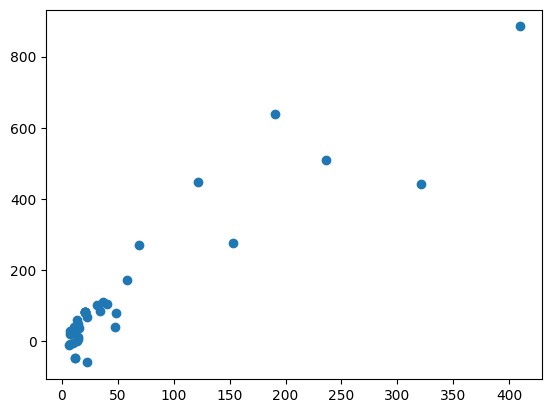

In [52]:
plt.scatter(a["risk"].values,a["return"].values)
plt.show()